In [103]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import quad 
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import os

In [104]:
# Leer el archivo CSV con separador y decimal correctos
df = pd.read_csv('Arcturus PEPSI 6000-6100.csv', sep=';')

fila_0 = df.iloc[0].astype(str).str.strip()
fila_0 = fila_0.replace('nan', '')

if fila_0.str.fullmatch(r'[:.,;\s]*').all():
    df = df.drop(index=0).reset_index(drop=True)

wavelength = df['Wavelength'].values

normalized_flux = df['Normalized Flux'].values

In [105]:
fe_1_lineas = [6003.0123, 6005.5413, 6007.7150, 6007.9601, 6008.5566, 6012.2099,
               6012.4377, 6015.2443, 6018.2995, 6019.3659, 6020.1692, 6021.7912, 
               6024.0580, 6027.0509, 6028.1067, 6034.0355, 6054.0741, 6056.0047, 
               6057.2585, 6060.6243, 6062.8484, 6078.4911, 6079.0093, 6082.7106, 
               6085.2590, 6093.6444, 6094.3736, 6096.6653, 6098.2447]


fe_1_lineas = np.array(fe_1_lineas, dtype = float)

In [106]:
z_max = 2e-5

resolucion = np.mean(np.diff(wavelength))
separacion_minima = round(np.min(np.diff(fe_1_lineas)),4)
distancia = int(np.ceil(separacion_minima/resolucion))

def encontrar_lambda_teorica(centro):
    diferencias = np.abs(fe_1_lineas - centro)
    tolerancias = z_max * fe_1_lineas + resolucion
    idx = np.argmin(diferencias)  
    if diferencias[idx] <= tolerancias[idx]:
        return fe_1_lineas[idx]
    else:
        return None

Comparación y Tabulación

In [107]:
inv_flux = 1 - normalized_flux
picos, _ = find_peaks(
    inv_flux,
    prominence=0.03,       
    distance=distancia,          
                   
)

picos_filtrados = []
for pico in picos:
    lambda_pico = wavelength[pico]
    lambda_teorica = encontrar_lambda_teorica(lambda_pico)
    if lambda_teorica is not None:
        picos_filtrados.append(pico)


ventana = 5
centros_interpolados = []
polinomios = []
area_polinomio_interpolador = []
profundidad_real = []

for pico in picos:
    if pico - ventana < 0 or pico + ventana >= len(wavelength):
        continue
    
    x = wavelength[pico - ventana:pico + ventana + 1]
    y = normalized_flux[pico - ventana:pico + ventana + 1]
    
   
    x_centro = x.mean()
    x_reubicado = x - x_centro

    
    coef = np.polyfit(x_reubicado, y, deg=4)
    p = Polynomial(coef[::-1])

 
    def polinomio_recentrado(lmbda):
        return p(lmbda - x_centro)

   
    area_polinomio, _ = quad(polinomio_recentrado, x[0], x[-1])
    area_polinomio_interpolador.append(area_polinomio)

    """
    profundidad_equivalente = (x[-1] - x[0]) - area_polinomio
    profundidad_real.append(profundidad_equivalente)

    """


    dp = p.deriv()
    raices = dp.roots()
    raices_reales = raices[np.isreal(raices)].real
    raices_en_intervalo = [r for r in raices_reales if x_reubicado.min() <= r <= x_reubicado.max()]
    
    if raices_en_intervalo:
        minimo_reubicado = raices_en_intervalo[np.argmin(p(raices_en_intervalo))]
        minimo = minimo_reubicado + x_centro   
        centros_interpolados.append(minimo)
        polinomios.append((p, x_centro))   


print(f"Total de picos detectados: {len(picos)}")

Total de picos detectados: 97


In [108]:
os.makedirs("graficas_lineas", exist_ok=True)

calculo_z = []
calculo_v = []
calculo_lambda = []
calculo_area = []
coeficiente_0 = []
coeficiente_1 = []
coeficiente_2 = []
coeficiente_3 = []
coeficiente_4 = []
flujo_centro_lista = []
f1_lista = []
f2_lista = []
f3_lista = []
profundidad_grafica = []

centro_filtrado = []
profundidad_filtrada_l = []

c_km_s = 299792

for i, (centro, (p, x_centro)) in enumerate(zip(centros_interpolados, polinomios)):

    lambda_teorica = encontrar_lambda_teorica(centro)
    if lambda_teorica is None:
        continue

    z = (centro - lambda_teorica) / lambda_teorica
    v = z * c_km_s

    if not (-2.0 <= v <= 2.0):
        continue


    centro_filtrado.append(centro)
    calculo_z.append(z)
    calculo_v.append(v)
    calculo_lambda.append(lambda_teorica)

    """
    profundidad_filtrada_l.append(profundidad_real[i])
    """

    indice_cercano = np.argmin(np.abs(wavelength - centro))
    if indice_cercano - ventana < 0 or indice_cercano + ventana >= len(wavelength):
        continue

    x = wavelength[indice_cercano - ventana: indice_cercano + ventana + 1]
    y = normalized_flux[indice_cercano - ventana: indice_cercano + ventana + 1]

    delta_lambda = np.diff(x)  
    altura_promedio = 1 - y[1:]
    area = np.sum(altura_promedio * delta_lambda) 

    calculo_area.append(area)



    x_fina = np.linspace(x[0], x[-1], 200)
    y_fina = p(x_fina - x_centro)

    flujo = p(centro-x_centro)
    flujo_centro_lista.append(flujo) 
    coef = p.coef

    ecuacion = r"$P(X) = {:.3e} + {:.3e}x + {:.3e}x^2 + {:.3e}x^3 + {:.3e}x^4$".format(
        coef[0], coef[1], coef[2], coef[3], coef[4])

    coeficiente_0.append(coef[0])
    coeficiente_1.append(coef[1])
    coeficiente_2.append(coef[2])
    coeficiente_3.append(coef[3])
    coeficiente_4.append(coef[4])

    flujo_f_1 = p.deriv(1)(centro-x_centro)
    f1_lista.append(flujo_f_1)

    flujo_f_2 = p.deriv(2)(centro-x_centro)
    f2_lista.append(flujo_f_2)
    
    flujo_f_3 = p.deriv(3)(centro-x_centro)
    f3_lista.append(flujo_f_3)

    profundidad_flujo = 1 - flujo
    profundidad_grafica.append(profundidad_flujo)

    

    leyenda = (f"Área = {area:.5f} Å\n"
               f"Coeficientes: \n {ecuacion} \n"
               f"Profundidad: = {profundidad_flujo:.4f} \n"
               f"Asimetría = {flujo_f_3:.4f}")
    
    plt.figure(figsize=(14, 7))
    plt.plot(x, y, label="Espectro")
    plt.plot(x_fina, y_fina, 'yellow', label="Interpolación polinómica")
    plt.fill_between(x, y, 1, color='pink', alpha=0.4, label=leyenda)
    plt.axvline(centro, color='purple', linestyle='--', lw=1, label="Centro interpolado")
    if lambda_teorica:
        plt.axvline(lambda_teorica, color='red', linestyle=':', lw=1, label="Línea teórica")
    plt.title(f"λ_obs (Å) = {centro:.4f}; z = {z:.3e}; v = {v:.3g} [km/s]")
    plt.xlabel("Longitud de onda [Å]")
    plt.ylabel("Flujo normalizado")
    plt.legend()
    plt.tight_layout()

    nombre_archivo = f"graficas_lineas/linea_{centro:.4f}.png"
    plt.savefig(nombre_archivo)
    plt.close()

#Aunque no se utilizan explicitamente f1 y f2, el primero sirvió para verificar que todos los centros interpolados fueran mínimos.El segundo sirvió para verificar la curvatura de estos mínimos por lo cual todos son positivos.



Resultados

In [109]:
resultados = pd.DataFrame({
    "λ_teo (Å)": calculo_lambda,
    "λ_obs (Å)": centro_filtrado,
    "Flujo": flujo_centro_lista,
    "Profundidad": profundidad_grafica,
    "z": calculo_z,
    "v_Doppler [km/s]": calculo_v,
    "Asimetría": f3_lista,
    "Área [Å^2]": calculo_area,
    "Constante": coeficiente_0,
    "x": coeficiente_1,
    "x^2": coeficiente_2,
    "x^3": coeficiente_3,
    "x^4": coeficiente_4,
})

resultados.style.format({
    "λ_teo (Å)": "{:.4f}",
    "λ_obs (Å)": "{:.4f}",
    "Flujo": "{:.4f}",
    "Profundidad": "{:.4f}",
    "z": "{:.3e}",
    "v_Doppler [km/s]": "{:.3e}",
    "Asimetría": "{:.4f}",
    "Área [Å^2]": "{:.5f}",
    "Constante": "{:.3e}",
    "x": "{:.3e}",
    "x^2": "{:.3e}",
    "x^3": "{:.3e}",
    "x^4": "{:.3e}"

})


,λ_teo (Å),λ_obs (Å),Flujo,Profundidad,z,v_Doppler [km/s],Asimetría,Área [Å^2],Constante,x,x^2,x^3,x^4
0,6003.0123,6003.0104,0.3471,0.6529,-3.229e-07,-9.680e-02,-149.5934,0.06595,3.486e-01,6.634e-01,7.508e+01,-9.322e+01,-3.888e+03
1,6005.5413,6005.5382,0.5043,0.4957,-5.231e-07,-1.568e-01,-135.1927,0.04827,5.044e-01,-6.608e-02,7.530e+01,-1.331e+01,-5.255e+03
2,6007.7150,6007.7045,0.9044,0.0956,-1.746e-06,-5.235e-01,-33.8373,0.00940,9.044e-01,3.370e-03,1.352e+01,-6.215e+00,-1.155e+03
3,6007.9601,6007.9568,0.5243,0.4757,-5.430e-07,-1.628e-01,-214.9429,0.04627,5.263e-01,-7.513e-01,6.947e+01,6.851e+01,-4.843e+03
4,6008.5566,6008.5560,0.3339,0.6661,-1.046e-07,-3.137e-02,-296.4388,0.06674,3.339e-01,3.634e-03,7.252e+01,-4.975e+01,-3.443e+03
5,6012.2099,6012.2119,0.4934,0.5066,3.284e-07,9.844e-02,-373.4776,0.04856,4.934e-01,-1.119e-01,7.237e+01,-4.856e+01,-4.424e+03
6,6015.2443,6015.2399,0.7521,0.2479,-7.319e-07,-2.194e-01,-238.6006,0.02280,7.522e-01,-1.490e-01,4.491e+01,-1.498e+01,-3.731e+03
7,6019.3659,6019.3618,0.8676,0.1324,-6.788e-07,-2.035e-01,-81.9647,0.01475,8.683e-01,-2.484e-01,2.084e+01,2.047e+01,-1.437e+03
8,6020.1692,6020.1639,0.4107,0.5893,-8.808e-07,-2.641e-01,622.4062,0.07078,4.109e-01,1.973e-01,5.752e+01,7.945e+01,-3.526e+03
9,6021.7912,6021.7921,0.2849,0.7151,1.457e-07,4.367e-02,70.9643,0.08818,2.850e-01,-1.211e-01,5.113e+01,1.659e+01,-1.006e+03


In [110]:
df.to_csv("tabla_resultados_arturo.csv", index=False)

In [ ]:
df = pd.DataFrame({
    "λ_teo (Å)": calculo_lambda,
    "λ_obs (Å)": centro_filtrado,
    "Flujo": flujo_centro_lista,
    "Profundidad": profundidad_grafica,
    "Velocidad (km/s)": calculo_v,
    "Asimetría":f3_lista,
    "Coef 0": coeficiente_0,
    "Coef 1": coeficiente_1,
    "Coef 2": coeficiente_2,
    "Coef 3": coeficiente_3,
    "Coef 4": coeficiente_4
})

df.to_csv("resultados_lineas.csv", index=False)

print("CSV guardado como resultados_lineas.csv")

CSV guardado como resultados_lineas.csv


Gráfica de velocidad en función de la profundidad

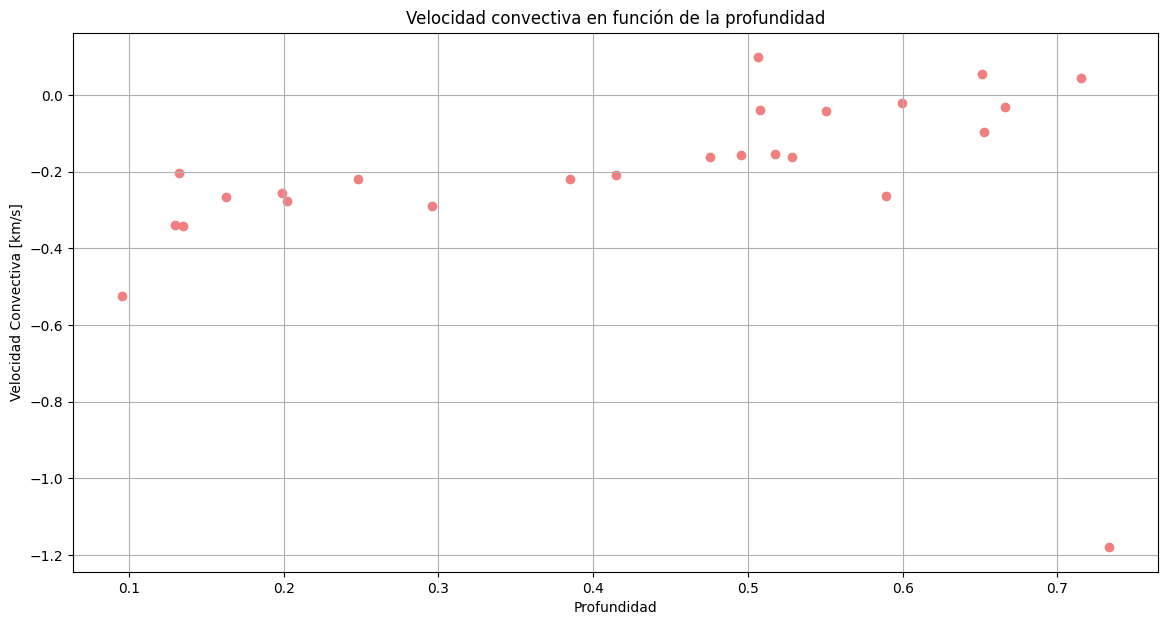

In [112]:
plt.figure(figsize=(14, 7))
plt.scatter(profundidad_grafica, calculo_v, color = "lightcoral")
plt.xlabel("Profundidad")
plt.ylabel("Velocidad Convectiva [km/s]")
plt.title("Velocidad convectiva en función de la profundidad")
plt.grid(True)
plt.show()